<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

**1.1 Импортируем необходимые библиотеки.**

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (f1_score,
                             roc_auc_score,
                             roc_curve,
                             accuracy_score,
                             confusion_matrix,
                             recall_score,
                             precision_score
                            )

import warnings
warnings.filterwarnings("ignore")

**1.2 Пользовательские функции.**

In [2]:
# Напишем функцию для первичной проверки данных

def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)
     
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T) 
    
    
    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')    
    df_object = data_df.select_dtypes(include='object').columns
    
    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())

**1.3 Загрузим данные.**

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

In [4]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


**1.4 Первичный осмотр данных.**

In [5]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ

check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
(10000, 14)

Проверка пропусков
Количество пропусков: 909
Доля про

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5.000500e+03,2886.895680,1.00,2500.75,5.000500e+03,7.500250e+03,10000.00
CustomerId,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
CreditScore,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
Tenure,9091.0,4.997690e+00,2.894723,0.00,2.00,5.000000e+00,7.000000e+00,10.00
Balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
NumOfProducts,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
HasCrCard,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
IsActiveMember,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
EstimatedSalary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48



Описание категориальных данных:


,count,unique,top,freq
Surname,10000,2932,Smith,32
Geography,10000,3,France,5014
Gender,10000,2,Male,5457



Вывод уникальных значений по каждому категориаьному признаку:
_Surname


Smith            32
Martin           29
Scott            29
Walker           28
Brown            26
                 ..
Builder           1
Milligan          1
Flannery          1
Sternberg         1
Ugonnatubelum     1
Name: Surname, Length: 2932, dtype: int64

_Geography


France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

_Gender


Male      5457
Female    4543
Name: Gender, dtype: int64

Вывод: 
- в таблице 10000 строк и 14 столбцов
- столбец 'Tenure' имеет 909 пропусков;
- дубликатов нет

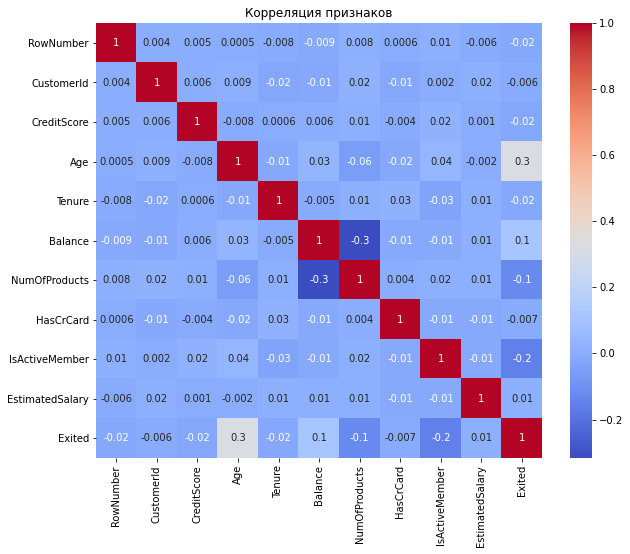

In [6]:
# Проверим на мультиколлинеарность 

plt.figure(figsize=(10, 8))
plt.title('Корреляция признаков')
sns.heatmap(df.corr(method='spearman'), annot = True, cmap="coolwarm", annot_kws={'size':10}, fmt='.1g')
plt.show()

Вывод: сильной связи между признаками нет, всё нормально.

**1.5 Предобработка данных.**

In [7]:
# Заполним пропущенные значения в столбце 'Tenure' медианой

df['Tenure'].fillna(int(df['Tenure'].median()), inplace=True) 

In [8]:
#Проверим

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Вывод: пропусков нет, всё нормально.

In [9]:
# Преобразуем категориальные признаки в численные
# Применим ОНЕ к столбцам 'Gender' и 'Geography'

df = pd.get_dummies(df, drop_first=True, columns=['Gender', 'Geography'])

In [10]:
# Проверим

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


In [11]:
# Удалим столбцы 'RowNumber', 'CustomerId' и'Surname',т.к. они не влияют на качество обучения

df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [12]:
# Проверим

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


In [13]:
# Приведём названия столбцов к нижнему регистру

df.columns = map(str.lower, df.columns)

In [14]:
# Приведём названия столбцов к змеиному регистру

df.rename(columns = {'creditscore': 'credit_score', 'numofproducts':'num_of_products', 
                     'hascrcard':'has_cr_card', 'isactivemember':'is_active_member',
                     'estimatedsalary':'estimated_salary'}, inplace = True )


In [15]:
# Проверим

df.columns

Index(['credit_score', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'exited',
       'gender_male', 'geography_germany', 'geography_spain'],
      dtype='object')

**1.6 Формирование выборок и отбор признаков.**

In [16]:
# Разделим на признаки и целевой признак

target = df['exited']
features = df.drop(['exited'], axis=1)


In [17]:
# Сформируем 3 выборки: обучающую (50%), тестовую (25%) и валидационную (25%) 

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.5, random_state=12345, stratify=target)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)


In [18]:
# Проверим

print(features_train.shape)
print(features_test.shape)
print(features_valid.shape)

(5000, 11)
(2500, 11)
(2500, 11)


**Масштабирование признаков.**

In [19]:
# Создадим переменную с численными признаками

numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

In [20]:
# Cоздадим объект структуры StandardScaler() и настроим его на обучающих данных

scaler = StandardScaler()
scaler.fit(features_train[numeric])

# Для обучающей выборки

features_train[numeric] = scaler.transform(features_train[numeric])

# Для тестовой выборки

features_test[numeric] = scaler.transform(features_test[numeric])

# Для валидационной выборки

features_valid[numeric] = scaler.transform(features_valid[numeric])


In [21]:
# Проверим

print(features_train[numeric].head())
print(features_test[numeric].head())
print(features_valid[numeric].head())

      credit_score       age    tenure   balance  num_of_products  \
5460      0.111187  0.193128  0.004225  0.740076         0.809174   
3610     -0.726970  1.626818 -1.452695  0.880243        -0.929489   
3892     -1.047746  0.575445  0.368455  0.766921        -0.929489   
4734     -0.623494  1.435659 -0.360005 -1.208445         0.809174   
6102     -0.085418 -0.284769  0.368455 -1.208445         0.809174   

      estimated_salary  
5460          0.368972  
3610          0.129920  
3892          0.816963  
4734         -0.098170  
6102         -0.026458  
      credit_score       age    tenure   balance  num_of_products  \
4492     -0.623494 -0.667086 -1.816925  0.822924        -0.929489   
5970     -1.865208 -0.380348 -1.452695  0.325435        -0.929489   
7940      1.352902 -0.953824  0.368455  0.361786        -0.929489   
9789     -0.416541  0.575445 -1.452695 -1.208445         0.809174   
4903      0.452659  0.288707 -0.724235  1.285614         0.809174   

      estimated_sala

**Вывод:**
- в таблице 10000 строк и 14 столбцов;
- заполнены пропуски в столбце 'Tenure';
- дубликаты не выявлены;
- мультиколлинеарность не выявлена;
- преобразованы категориальные признаки в численные;
- удалены столбцы 'RowNumber', 'CustomerId' и'Surname',т.к. они не влияют на качество обучения;
- приведены названия столбцов к змеиному регистру;
- сформированы выборки: обучающая (50%), тестовая (25%) и валидационная (25%);
- отбораны признаки;
- произведено масштабирование признаков.


## Исследование задачи

**2.1 Исследуем баланс классов.**

0    0.7963
1    0.2037
Name: exited, dtype: float64


<AxesSubplot:title={'center':'Частота класса'}>

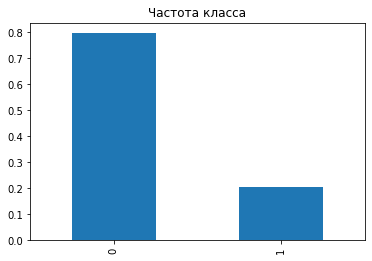

In [22]:
class_frequency = df['exited'].value_counts(normalize=bool)
print(class_frequency)
class_frequency.plot(kind='bar', title='Частота класса')

В нашей задаче наблюдается сильный дисбаланс классов, что плохо сказывется на обучении модели. 

Обучим модели без учёта дисбаланса

**2.2 Исследуем модель - _Решающее дерево_.**

In [23]:
best_depth_dtc = 0
best_f1_dtc = 0
best_result_dtc = 0

for depth_dtc in range(1,11):
    
    # Инициализируем модель DecisionTreeClassifier с параметром random_state=12345 и max_depth=depth
    
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth_dtc) 
    
    # Обучим модель на тренировочной выборке
    
    model_dtc.fit(features_train, target_train) 
    
    # Получим предсказания модели на валидационной выборке 
    
    predictions_valid_dtc = model_dtc.predict(features_valid) 
    
    # посчитаем качество модели на валидационной выборке
    
    result_dtc = accuracy_score(target_valid, predictions_valid_dtc)
    
    # Посчитаем точность модели 
    
    f1_dtc = f1_score(target_valid, predictions_valid_dtc)
    
    if f1_dtc > best_f1_dtc:
        best_depth_dtc = depth_dtc
        best_f1_dtc = f1_dtc
        best_result_dtc = result_dtc
        
print('F1-мера:', best_f1_dtc, ', глубина дерева -', best_depth_dtc)
print('Accuracy наилучшей модели на валидационной выборке:', best_result_dtc)
probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_dtc))

F1-мера: 0.581986143187067 , глубина дерева - 7
Accuracy наилучшей модели на валидационной выборке: 0.8552
AUC-ROC: 0.7303440136804225


Проанализируем частоты классов в результатах предсказаний решающего дерева: 

0    0.8284
1    0.1716
dtype: float64


<AxesSubplot:title={'center':'Частота классов Решающего дерева'}>

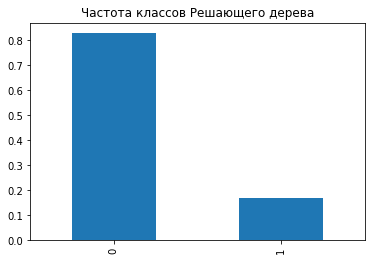

In [24]:
predicted_valid_dtc = pd.Series(model_dtc.predict(features_valid))

class_frequency_dtc = predicted_valid_dtc.value_counts(normalize=bool)
print(class_frequency_dtc)
class_frequency_dtc.plot(kind='bar', title='Частота классов Решающего дерева')

Мало что изменилось.

In [25]:
# Построим матрицу ошибок 

print(confusion_matrix(target_valid, predictions_valid_dtc))

[[1813  178]
 [ 258  251]]


**2.3 Исследуем модель - _Случайный лес_.**

In [26]:
best_f1_rfr = 0
best_est_rfr = 0
best_depth_rfr = 0
best_result_rfr = 0

for est_rfr in range(10, 100, 10):
    for depth_rfr in range (1, 11):
        
        # Инициализируем модель RandomForestClassifier 
        # с параметрами random_state=12345, n_estimators=est и max_depth=depth
        
        model_rfr = RandomForestClassifier(random_state=12345, n_estimators=est_rfr, max_depth=depth_rfr) 
        
        # Обучим модель на тренировочной выборке
        
        model_rfr.fit(features_train, target_train) 
        
        # Получим предсказания модели на валидационной выборке
        
        predictions_valid_rfr = model_rfr.predict(features_valid)
        
        # посчитаем качество модели на валидационной выборке
        
        result_rfr = accuracy_score(target_valid, predictions_valid_rfr)
        
        # Посчитаем точность модели 
        
        f1_rfr = f1_score(target_valid, predictions_valid_rfr)
        
        
    
        if f1_rfr > best_f1_rfr:
            best_f1_rfr = f1_rfr
            best_depth_rfr = depth_rfr
            best_est_rfr = est_rfr
            best_result_rfr = result_rfr
            
print('F1-мера:', best_f1_rfr, 
      ', глубина дерева -', best_depth_rfr, ', количество деревьев - ', best_est_rfr
     )
print('Accuracy наилучшей модели на валидационной выборке:', best_result_rfr)
probabilities_valid_rfr = model_rfr.predict_proba(features_valid)
probabilities_one_valid_rfr = probabilities_valid_rfr[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_rfr))

F1-мера: 0.588235294117647 , глубина дерева - 10 , количество деревьев -  50
Accuracy наилучшей модели на валидационной выборке: 0.8628
AUC-ROC: 0.8572673297027193


Проанализируем частоты классов в результатах предсказаний случайного леса: 

0    0.8764
1    0.1236
dtype: float64


<AxesSubplot:title={'center':'Частота классов Случайного леса'}>

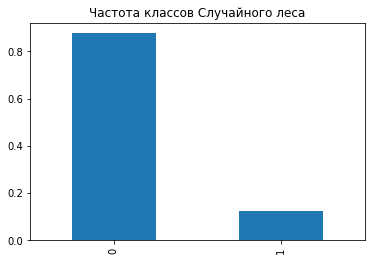

In [27]:
predicted_valid_rfr = pd.Series(model_rfr.predict(features_valid))

class_frequency_rfr = predicted_valid_rfr.value_counts(normalize=bool)
print(class_frequency_rfr)
class_frequency_rfr.plot(kind='bar', title='Частота классов Случайного леса')

Изменения лучше, но не достаточно.

In [28]:
# Построим матрицу ошибок 

print(confusion_matrix(target_valid, predictions_valid_rfr))

[[1920   71]
 [ 271  238]]


**2.4 Исследуем модель - _Логистическая регрессия_.**

In [29]:
# Инициализируем модель LogisticRegression с параметрами random_state=12345, solver='liblinear'

model_lr = LogisticRegression(random_state=12345, solver='liblinear')

# Обучим модель на тренировочной выборке

model_lr.fit(features_train, target_train) 

# Получим предсказания модели на валидационной выборке

predictions_valid_lr = model_lr.predict(features_valid)

# посчитаем качество модели на валидационной выборке

result_lr = accuracy_score(target_valid, predictions_valid_lr)

# Посчитаем точность модели 

f1_lr = f1_score(target_valid, predictions_valid_lr)

print('Accuracy наилучшей модели на валидационной выборке:', result_lr)
print('F1-мера:', f1_lr)
probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_lr))

Accuracy наилучшей модели на валидационной выборке: 0.8148
F1-мера: 0.3299565846599131
AUC-ROC: 0.777658599256576


Проанализируем частоты классов в результатах предсказаний логистической регрессии: 

0    0.9272
1    0.0728
dtype: float64


<AxesSubplot:title={'center':'Частота классов Логистической регрессии'}>

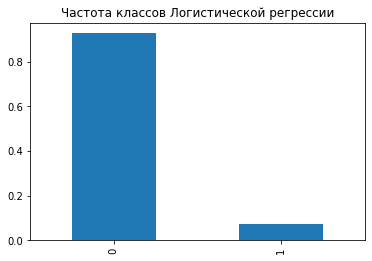

In [30]:
predicted_valid_lr = pd.Series(model_lr.predict(features_valid))

class_frequency_lr = predicted_valid_lr.value_counts(normalize=bool)
print(class_frequency_lr)
class_frequency_lr.plot(kind='bar', title='Частота классов Логистической регрессии')

Самый лучший результат, но модель выдаёт на 93% одинаковый результат - ноль.

In [31]:
# Построим матрицу ошибок 

print(confusion_matrix(target_valid, predictions_valid_lr))

[[1923   68]
 [ 395  114]]


In [32]:
# Создадим константную модель

target_pred_constant = pd.Series(0, index=target.index)
print(accuracy_score(target, target_pred_constant))

0.7963


**Вывод:**
- обучив модели без учета дисбаланса классов, наилучшее значение метрик демонстрирует модель _Случайный лес_: \
При глубине дерева - 10 и количестве деревьев -  50: \
F1-мера: 0.588235294117647 \
Accuracy наилучшей модели на валидационной выборке: 0.8628 \
Площадь ROC-кривой: 0.8572673297027193 
- наблюдается дисбаланс классов;
- по матрице видно, что модель часто ошибается и предсказывает отрицательные ответы там, где их нет.

## Борьба с дисбалансом

**3.1 Взвешивание классов.**

In [33]:
# Сделаем веса классов сбалансированными у Решающего дерева

best_depth_dtc = 0
best_f1_dtc = 0
best_result_dtc = 0

for depth_dtc in range(1,11):
     
    # Инициализируем модель DecisionTreeClassifier с параметрам:
    # random_state=12345, max_depth=depth и class_weight='balanced'
    
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth_dtc, class_weight='balanced') 
    
    # Обучим модель на тренировочной выборке
    
    model_dtc.fit(features_train, target_train) 
    
    # Получим предсказания модели на валидационной выборке 
    
    predictions_valid_dtc = model_dtc.predict(features_valid) 
    
    # посчитаем качество модели на валидационной выборке
    
    result_dtc = accuracy_score(target_valid, predictions_valid_dtc)
    
    # Посчитаем точность модели 
    
    f1_dtc = f1_score(target_valid, predictions_valid_dtc)
    
    if f1_dtc > best_f1_dtc:
        best_depth_dtc = depth_dtc
        best_f1_dtc = f1_dtc
        best_result_dtc = result_dtc
        
print('F1-мера:', best_f1_dtc, ', глубина дерева -', best_depth_dtc)
print('Accuracy наилучшей модели на валидационной выборке:', best_result_dtc)

F1-мера: 0.5597484276729561 , глубина дерева - 6
Accuracy наилучшей модели на валидационной выборке: 0.776


In [34]:
%%time

# Обучим модель

model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=6, class_weight='balanced') 
model_dtc.fit(features_train, target_train) 
predictions_valid_dtc = model_dtc.predict(features_valid) 

print('Полнота:', recall_score(target_valid, predictions_valid_dtc))
print('Точность:', precision_score(target_valid, predictions_valid_dtc))
print('F1-мера:', f1_score(target_valid, predictions_valid_dtc)) 
probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_dtc))


Полнота: 0.6994106090373281
Точность: 0.46657929226736566
F1-мера: 0.5597484276729561
AUC-ROC: 0.8240638867043147
CPU times: user 33 ms, sys: 54 µs, total: 33.1 ms
Wall time: 45.9 ms


In [35]:
# Сделаем веса классов сбалансированными у модели Случайный лес

best_f1_rfr = 0
best_est_rfr = 0
best_depth_rfr = 0
best_result_rfr = 0

for est_rfr in range(10, 100, 10):
    for depth_rfr in range (1, 11):
        
        # Инициализируем модель RandomForestClassifier 
        # с параметрами random_state=12345, n_estimators=est, max_depth=depth и class_weight='balanced'
        
        model_rfr = RandomForestClassifier(random_state=12345, n_estimators=est_rfr, 
                                           max_depth=depth_rfr, class_weight='balanced') 
        
        # Обучим модель на тренировочной выборке
        
        model_rfr.fit(features_train, target_train) 
        
        # Получим предсказания модели на валидационной выборке
        
        predictions_valid_rfr = model_rfr.predict(features_valid)
        
        # посчитаем качество модели на валидационной выборке
        
        result_rfr = accuracy_score(target_valid, predictions_valid_rfr)
        
        # Посчитаем точность модели 
        
        f1_rfr = f1_score(target_valid, predictions_valid_rfr)
        
        
    
        if f1_rfr > best_f1_rfr:
            best_f1_rfr = f1_rfr
            best_depth_rfr = depth_rfr
            best_est_rfr = est_rfr
            best_result_rfr = result_rfr
            
print('F1-мера:', best_f1_rfr, 
      ', глубина дерева -', best_depth_rfr, ', количество деревьев - ', best_est_rfr
     )
print('Accuracy наилучшей модели на валидационной выборке:', best_result_rfr)



F1-мера: 0.6307977736549165 , глубина дерева - 9 , количество деревьев -  50
Accuracy наилучшей модели на валидационной выборке: 0.8408


In [36]:
%%time

# Обучим модель

model_rfr = RandomForestClassifier(random_state=12345, n_estimators=50, 
                                   max_depth=9, class_weight='balanced') 
model_rfr.fit(features_train, target_train) 
predictions_valid_rfr = model_rfr.predict(features_valid)
        

print('Полнота:', recall_score(target_valid, predictions_valid_rfr))
print('Точность:', precision_score(target_valid, predictions_valid_rfr))
print('F1-мера:', f1_score(target_valid, predictions_valid_rfr)) 
probabilities_valid_rfr = model_rfr.predict_proba(features_valid)
probabilities_one_valid_rfr = probabilities_valid_rfr[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_rfr))


Полнота: 0.6679764243614931
Точность: 0.5975395430579965
F1-мера: 0.6307977736549165
AUC-ROC: 0.858353751015128
CPU times: user 292 ms, sys: 7.58 ms, total: 300 ms
Wall time: 308 ms


In [37]:
%%time

# Сделаем веса классов сбалансированными у Логистической регрессии

# Инициализируем модель LogisticRegression с параметрами:
# random_state=12345, solver='liblinear' и class_weight='balanced'

model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

# Обучим модель на тренировочной выборке

model_lr.fit(features_train, target_train) 

# Получим предсказания модели на валидационной выборке

predictions_valid_lr = model_lr.predict(features_valid)

# посчитаем качество модели на валидационной выборке

result_lr = accuracy_score(target_valid, predictions_valid_lr)

# Посчитаем точность модели 

f1_lr = f1_score(target_valid, predictions_valid_lr)

print('Accuracy наилучшей модели на валидационной выборке:', result_lr)
print('F1-мера:', f1_lr)


Accuracy наилучшей модели на валидационной выборке: 0.7164
F1-мера: 0.5038488453463961
CPU times: user 14.5 ms, sys: 28 ms, total: 42.5 ms
Wall time: 18.1 ms


In [38]:
print('Полнота:', recall_score(target_valid, predictions_valid_lr))
print('Точность:', precision_score(target_valid, predictions_valid_lr))
print('F1-мера:', f1_score(target_valid, predictions_valid_lr)) 
probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_lr))


Полнота: 0.7072691552062869
Точность: 0.391304347826087
F1-мера: 0.5038488453463961
AUC-ROC: 0.7825124652290909


Лучший результат после взвешивания классов показала модель _Случайный лес_:
- F1-мера: 0.6307977736549165
- Площадь ROC-кривой: 0.858353751015128

**3.2 Увеличение выборки.**

In [39]:
# Создадим функцию upsample() и увеличим выборку в 4 раза

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(8057, 11)
(8057,)


**Обучим модели на новых данных.**

In [40]:
# подберем лучшие гиперпараметры для Решающего дерева

best_depth_dtc = 0
best_f1_dtc = 0
best_result_dtc = 0

for depth_dtc in range(1,11):
    
    model_dtc_upsampled = DecisionTreeClassifier(random_state=12345, max_depth=depth_dtc) 
    model_dtc_upsampled.fit(features_upsampled, target_upsampled) 
    predictions_valid_dtc = model_dtc_upsampled.predict(features_valid) 
    result_dtc = accuracy_score(target_valid, predictions_valid_dtc)
    f1_dtc = f1_score(target_valid, predictions_valid_dtc)
    
    if f1_dtc > best_f1_dtc:
        best_depth_dtc = depth_dtc
        best_f1_dtc = f1_dtc
        best_result_dtc = result_dtc
        
print('F1-мера:', best_f1_dtc, ', глубина дерева -', best_depth_dtc)
print('Accuracy наилучшей модели на валидационной выборке:', best_result_dtc)
probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_dtc))



F1-мера: 0.5638629283489096 , глубина дерева - 6
Accuracy наилучшей модели на валидационной выборке: 0.776
AUC-ROC: 0.8240638867043147


In [41]:
%%time

# Решающее дерево

model_dtc_upsampled = DecisionTreeClassifier(random_state=12345, max_depth=6) 
model_dtc_upsampled.fit(features_upsampled, target_upsampled) 
predictions_valid_dtc_upsampled = model_dtc_upsampled.predict(features_valid) 

print('Полнота:', recall_score(target_valid, predictions_valid_dtc_upsampled))
print('Точность:', precision_score(target_valid, predictions_valid_dtc_upsampled))
print('F1-мера:', f1_score(target_valid, predictions_valid_dtc_upsampled)) 
probabilities_valid_dtc_upsampled = model_dtc_upsampled.predict_proba(features_valid)
probabilities_one_valid_dtc_upsampled = probabilities_valid_dtc_upsampled[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_dtc_upsampled))

    


Полнота: 0.7111984282907662
Точность: 0.4670967741935484
F1-мера: 0.5638629283489096
AUC-ROC: 0.821525943365972
CPU times: user 33.6 ms, sys: 61 µs, total: 33.7 ms
Wall time: 30.8 ms


In [42]:
# Подберем лучшие гиперпараметры для Случайного леса

best_f1_rfr = 0
best_est_rfr = 0
best_depth_rfr = 0
best_result_rfr = 0

for est_rfr in range(10, 100, 10):
    for depth_rfr in range (1, 11):
        model_rfr_upsampled = RandomForestClassifier(random_state=12345, n_estimators=est_rfr, max_depth=depth_rfr) 
        model_rfr_upsampled.fit(features_upsampled, target_upsampled) 
        predictions_valid_rfr = model_rfr_upsampled.predict(features_valid)
        result_rfr = accuracy_score(target_valid, predictions_valid_rfr)
        f1_rfr = f1_score(target_valid, predictions_valid_rfr)
              
        if f1_rfr > best_f1_rfr:
            best_f1_rfr = f1_rfr
            best_depth_rfr = depth_rfr
            best_est_rfr = est_rfr
            best_result_rfr = result_rfr
            
print('F1-мера:', best_f1_rfr, 
      ', глубина дерева -', best_depth_rfr, ', количество деревьев - ', best_est_rfr
     )
print('Accuracy наилучшей модели на валидационной выборке:', best_result_rfr)
probabilities_valid_rfr = model_rfr.predict_proba(features_valid)
probabilities_one_valid_rfr = probabilities_valid_rfr[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_rfr))

F1-мера: 0.6271777003484321 , глубина дерева - 10 , количество деревьев -  60
Accuracy наилучшей модели на валидационной выборке: 0.8288
AUC-ROC: 0.858353751015128


In [43]:
%%time

# Случайный лес

model_rfr_upsampled = RandomForestClassifier(random_state=12345, n_estimators=60, max_depth=10) 
model_rfr_upsampled.fit(features_upsampled, target_upsampled) 
predictions_valid_rfr_upsampled = model_rfr_upsampled.predict(features_valid)
        

print('Полнота:', recall_score(target_valid, predictions_valid_rfr_upsampled))
print('Точность:', precision_score(target_valid, predictions_valid_rfr_upsampled))
print('F1-мера:', f1_score(target_valid, predictions_valid_rfr_upsampled)) 
probabilities_valid_rfr_upsampled = model_rfr_upsampled.predict_proba(features_valid)
probabilities_one_valid_rfr_upsampled = probabilities_valid_rfr_upsampled[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_rfr_upsampled))


Полнота: 0.7072691552062869
Точность: 0.5633802816901409
F1-мера: 0.6271777003484321
AUC-ROC: 0.8590207998863254
CPU times: user 459 ms, sys: 0 ns, total: 459 ms
Wall time: 471 ms


In [44]:
%%time

# Логистическая регрессия

model_lr_upsampled  = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_upsampled .fit(features_upsampled, target_upsampled) 
predictions_valid_lr_upsampled  = model_lr_upsampled .predict(features_valid)

print('Полнота:', recall_score(target_valid, predictions_valid_lr_upsampled))
print('Точность:', precision_score(target_valid, predictions_valid_lr_upsampled))
print('F1-мера:', f1_score(target_valid, predictions_valid_lr_upsampled)) 
probabilities_valid_lr_upsampled = model_lr_upsampled.predict_proba(features_valid)
probabilities_one_valid_lr_upsampled = probabilities_valid_lr_upsampled[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_lr_upsampled))



Полнота: 0.7072691552062869
Точность: 0.39087947882736157
F1-мера: 0.5034965034965035
AUC-ROC: 0.7825016108835536
CPU times: user 56.4 ms, sys: 79.7 ms, total: 136 ms
Wall time: 79.1 ms


Лучший результат также остался у модели _Случайный лес:_
- F1-мера: 0.6271777003484321
- Площадь ROC-кривой: 0.8590207998863254

Полнота увеличилась, а точность уменьшилась. 

**3.3 Уменьшение выборки.**

In [45]:
# Создадим функцию downsample() и уменьшим выборку в 4 раза

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

**Обучим модели на новых данных.**

In [46]:
# подберем лучшие гиперпараметры для Решающего дерева

best_depth_dtc = 0
best_f1_dtc = 0
best_result_dtc = 0

for depth_dtc in range(1,11):
    
    model_dtc_downsampled = DecisionTreeClassifier(random_state=12345, max_depth=depth_dtc) 
    model_dtc_downsampled.fit(features_downsampled, target_downsampled) 
    predictions_valid_dtc = model_dtc_downsampled.predict(features_valid) 
    result_dtc = accuracy_score(target_valid, predictions_valid_dtc)
    f1_dtc = f1_score(target_valid, predictions_valid_dtc)
    
    if f1_dtc > best_f1_dtc:
        best_depth_dtc = depth_dtc
        best_f1_dtc = f1_dtc
        best_result_dtc = result_dtc
        
print('F1-мера:', best_f1_dtc, ', глубина дерева -', best_depth_dtc)
print('Accuracy наилучшей модели на валидационной выборке:', best_result_dtc)
probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_dtc))


F1-мера: 0.5653450807635829 , глубина дерева - 5
Accuracy наилучшей модели на валидационной выборке: 0.7632
AUC-ROC: 0.8240638867043147


In [47]:
%%time

# Решающее дерево

model_dtc_downsampled = DecisionTreeClassifier(random_state=12345, max_depth=5) 
model_dtc_downsampled.fit(features_downsampled, target_downsampled) 
predictions_valid_dtc_downsampled = model_dtc_downsampled.predict(features_valid) 

print('Полнота:', recall_score(target_valid, predictions_valid_dtc_downsampled))
print('Точность:', precision_score(target_valid, predictions_valid_dtc_downsampled))
print('F1-мера:', f1_score(target_valid, predictions_valid_dtc_downsampled)) 
probabilities_valid_dtc_downsampled = model_dtc_downsampled.predict_proba(features_valid)
probabilities_one_valid_dtc_downsampled = probabilities_valid_dtc_downsampled[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_dtc_downsampled))
   

Полнота: 0.756385068762279
Точность: 0.451348182883939
F1-мера: 0.5653450807635829
AUC-ROC: 0.8320645261239427
CPU times: user 23.2 ms, sys: 92 µs, total: 23.3 ms
Wall time: 20.5 ms


In [48]:
# Подберем лучшие гиперпараметры для Случайного леса

best_f1_rfr = 0
best_est_rfr = 0
best_depth_rfr = 0
best_result_rfr = 0

for est_rfr in range(10, 100, 10):
    for depth_rfr in range (1, 11):
        model_rfr_downsampled = RandomForestClassifier(random_state=12345, n_estimators=est_rfr, max_depth=depth_rfr) 
        model_rfr_downsampled.fit(features_downsampled, target_downsampled) 
        predictions_valid_rfr = model_rfr_downsampled.predict(features_valid)
        result_rfr = accuracy_score(target_valid, predictions_valid_rfr)
        f1_rfr = f1_score(target_valid, predictions_valid_rfr)
              
        if f1_rfr > best_f1_rfr:
            best_f1_rfr = f1_rfr
            best_depth_rfr = depth_rfr
            best_est_rfr = est_rfr
            best_result_rfr = result_rfr
            
print('F1-мера:', best_f1_rfr, 
      ', глубина дерева -', best_depth_rfr, ', количество деревьев - ', best_est_rfr
     )
print('Accuracy наилучшей модели на валидационной выборке:', best_result_rfr)
probabilities_valid_rfr = model_rfr.predict_proba(features_valid)
probabilities_one_valid_rfr = probabilities_valid_rfr[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_rfr))

F1-мера: 0.601823708206687 , глубина дерева - 9 , количество деревьев -  70
Accuracy наилучшей модели на валидационной выборке: 0.7904
AUC-ROC: 0.858353751015128


In [49]:
%%time

# Случайный лес

model_rfr_downsampled = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth=9) 
model_rfr_downsampled.fit(features_downsampled, target_downsampled) 
predictions_valid_rfr_downsampled = model_rfr_downsampled.predict(features_valid)
        

print('Полнота:', recall_score(target_valid, predictions_valid_rfr_downsampled))
print('Точность:', precision_score(target_valid, predictions_valid_rfr_downsampled))
print('F1-мера:', f1_score(target_valid, predictions_valid_rfr_downsampled)) 
probabilities_valid_rfr_downsampled = model_rfr_downsampled.predict_proba(features_valid)
probabilities_one_valid_rfr_downsampled = probabilities_valid_rfr_downsampled[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_rfr_downsampled))


Полнота: 0.7779960707269156
Точность: 0.49070631970260226
F1-мера: 0.601823708206687
AUC-ROC: 0.8569229509215832
CPU times: user 250 ms, sys: 7.86 ms, total: 258 ms
Wall time: 267 ms


In [50]:
%%time

# Логистическая регрессия

model_lr_downsampled = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr_downsampled.fit(features_downsampled, target_downsampled) 
predictions_valid_lr_downsampled = model_lr_downsampled.predict(features_valid)

print('Полнота:', recall_score(target_valid, predictions_valid_lr_downsampled))
print('Точность:', precision_score(target_valid, predictions_valid_lr_downsampled))
print('F1-мера:', f1_score(target_valid, predictions_valid_lr_downsampled)) 
probabilities_valid_lr_downsampled = model_lr_downsampled.predict_proba(features_valid)
probabilities_one_valid_lr_downsampled = probabilities_valid_lr_downsampled[:, 1]
print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid_lr_downsampled))


Полнота: 0.7013752455795678
Точность: 0.39932885906040266
F1-мера: 0.5089094796863863
AUC-ROC: 0.7802666024615682
CPU times: user 23.6 ms, sys: 35.1 ms, total: 58.8 ms
Wall time: 44.3 ms


После уменьшения выборки - качество модели _Случайный Лес_ снизилось, точность еще уменьшилась, а полнота увеличилась.

**Вывод:**

Лучшие показатели у модели _Случайный Лес:_

1. **После взвешивания классов:** \
Полнота: 0.6679764243614931 \
Точность: 0.5975395430579965 \
F1-мера: 0.6307977736549165 \
Площадь ROC-кривой: 0.858353751015128



2. **После увеличения выборки:** \
Полнота: 0.7072691552062869 \
Точность: 0.5633802816901409 \
F1-мера: 0.6271777003484321 \
Площадь ROC-кривой: 0.8590207998863254



3. **После уменьшения выборки:** \
Полнота: 0.7779960707269156 \
Точность: 0.49070631970260226 \
F1-мера: 0.601823708206687 \
Площадь ROC-кривой: 0.8569229509215832 


Для тестирования будем использовать модель _Случайный Лес_ после взвешивания классов. \
При глубине дерева - 9 и количестве деревьев -  50. \
Самые плохие показатели у _Логистической Регрессии._

## Тестирование модели

In [51]:
# проверим модель Случайный лес, т.к. она показала самый точный результат

test_predictions = model_rfr.predict(features_test)

print('Полнота:', recall_score(target_test, test_predictions))
print('Точность:', precision_score(target_test, test_predictions))
print('F1-мера:', f1_score(target_test, test_predictions)) 
probabilities_valid_test = model_rfr.predict_proba(features_test)
probabilities_one_valid_test = probabilities_valid_test[:, 1]
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_valid_test))


Полнота: 0.6208251473477406
Точность: 0.5862708719851577
F1-мера: 0.6030534351145038
AUC-ROC: 0.8539912908678444


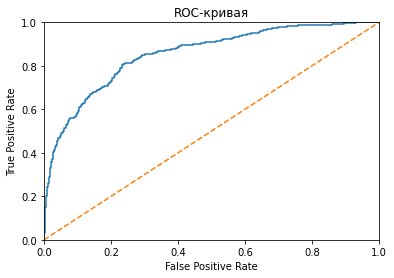

In [52]:
# Построим ROC-кривую

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [53]:
# создадим константную модель

target_pred_constant = pd.Series(1, index=target.index)
print('Полнота:', recall_score(target, target_pred_constant))
print('F1-мера:', f1_score(target, target_pred_constant)) 
print(accuracy_score(target, target_pred_constant))

Полнота: 1.0
F1-мера: 0.3384564260197724
0.2037


In [54]:
# Проверим модель на адекватность

dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
print('F1-мера:', f1_score(dummy_model.predict(features_test), target_test))

F1-мера: 0.3383183781987371


**Вывод:** \
Мы достигли поставленной цели и получили метрику F1 равную: \
F1-мера: 0.6030534351145038

**Общий вывод:** \
1. **_Были подготовлены данные:_**
- в таблице 10000 строк и 14 столбцов;
- заполнены пропуски в столбце 'Tenure';
- дубликаты не выявлены;
- мультиколлинеарность не выявлена;
- преобразованы категориальные признаки в численные;
- удалены столбцы 'RowNumber', 'CustomerId' и'Surname',т.к. они не влияют на качество обучения;
- приведены названия столбцов к змеиному регистру;
- сформированы выборки: обучающая (50%), тестовая (25%) и валидационная (25%);
- отбораны признаки;
- произведено масштабирование признаков.

2. **_Были исследованы задачи:_**
- обучив модели без учета дисбаланса классов, наилучшее значение метрик демонстрирует модель _Случайный лес_: \
При глубине дерева - 10 и количестве деревьев -  50: \
F1-мера: 0.588235294117647 \
Accuracy наилучшей модели на валидационной выборке: 0.8628 \
Площадь ROC-кривой: 0.8572673297027193 
- наблюдается дисбаланс классов;
- по матрице видно, что модель часто ошибается и предсказывает отрицательные ответы там, где их нет.

3. **_Была произведена борьба с дисбалансом тремя методами:_**
- взешивание классов;
- увеличение выборки;
- уменьшение выборки;

Лучшие показатели у модели _Случайный Лес:_

1. **После взвешивания классов:** \
Полнота: 0.6679764243614931 \
Точность: 0.5975395430579965 \
F1-мера: 0.6307977736549165 \
Площадь ROC-кривой: 0.858353751015128



2. **После увеличения выборки:** \
Полнота: 0.7072691552062869 \
Точность: 0.5633802816901409 \
F1-мера: 0.6271777003484321 \
Площадь ROC-кривой: 0.8590207998863254



3. **После уменьшения выборки:** \
Полнота: 0.7779960707269156 \
Точность: 0.49070631970260226 \
F1-мера: 0.601823708206687 \
Площадь ROC-кривой: 0.8569229509215832 

- самые плохие показатели у _Логистической Регрессии._

4. **_Было произведено тестирование модели._**
- для тестирования использовалась модель _Случайный лес_ после взвешивания классов;
- при глубине дерева - 9 и количестве деревьев -  50. 
- мы достигли поставленной цели и получили метрику F1 равную: \
F1-мера: 0.6030534351145038 
- построили ROC-кривую, AUC-ROC: 0.8539912908678444


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*